# NetCDF handling

NetCDF formatted files are much faster to read and write for large datasets. In order to make the most of this, both the `ScmDataFrame` and `ScmRun` objects have the ability to read and write netCDF files.

In [1]:
# NBVAL_IGNORE_OUTPUT
import traceback
from glob import glob

import numpy as np
import xarray as xr

from scmdata.run import ScmRun, df_append
from scmdata.netcdf import nc_to_run

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
OUT_FNAME = "/tmp/out_runs.nc"

In [3]:
def new_timeseries(
    n=100,
    count=1,
    model="example",
    scenario="ssp119",
    variable="Surface Temperature",
    cls=ScmRun,
    **kwargs,
):
    data = np.random.rand(n, count) * np.arange(n)[:, np.newaxis]
    index = 2000 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "scenario": scenario,
            "variable": variable,
            "region": "World",
            "unit": "K",
            **kwargs,
        },
        index=index,
    )

Let's create an `ScmRun` which contains a few variables and a number of runs. Such a dataframe would be used to store the results from an ensemble of simple climate model runs.

In [4]:
# NBVAL_IGNORE_OUTPUT
runs = df_append(
    [
        new_timeseries(
            count=3,
            variable=[
                "Surface Temperature",
                "Atmospheric Concentrations|CO2",
                "Radiative Forcing",
            ],
            run_id=run_id,
        )
        for run_id in range(10)
    ]
)
runs

<scmdata.ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	      model scenario                        variable region unit  run_id
	0   example   ssp119             Surface Temperature  World    K       0
	1   example   ssp119  Atmospheric Concentrations|CO2  World    K       0
	2   example   ssp119               Radiative Forcing  World    K       0
	3   example   ssp119             Surface Temperature  World    K       1
	4   example   ssp119  Atmospheric Concentrations|CO2  World    K       1
	5   example   ssp119               Radiative Forcing  World    K       1
	6   example   ssp119             Surface Temperature  World    K       2
	7   example   ssp119  Atmospheric Concentrations|CO2  World    K       2
	8   example   ssp119               Radiative Forcing  World    K       2
	9   example   ssp119             Surface Temperature  World    K       3
	10  example   ssp119  Atmospheric Concentrations|CO2  World    K    

## Reading/Writing to NetCDF4

Writing the runs to disk is easy. The one trick is that each variable and dimension combination must have unique metadata. If they do not, you will receive an error message like the below.

In [5]:
try:
    runs.to_nc(OUT_FNAME, dimensions=["region"])
except ValueError:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
ValueError: region dimension is not unique for variable Atmospheric Concentrations|CO2


In our dataset, there is more than one "run_id" per variable hence we need to add an additional dimension: `run_id`.

In [6]:
runs.to_nc(OUT_FNAME, dimensions=["run_id"])

The output netCDF file can be read using the `from_nc` method, `nc_to_run` function or directly using `xarray`.

In [7]:
# NBVAL_IGNORE_OUTPUT
ScmRun.from_nc(OUT_FNAME)

<scmdata.ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	    run_id                        variable region scenario    model unit
	30       0  Atmospheric Concentrations|Co2  World   ssp119  example    K
	31       1  Atmospheric Concentrations|Co2  World   ssp119  example    K
	32       2  Atmospheric Concentrations|Co2  World   ssp119  example    K
	33       3  Atmospheric Concentrations|Co2  World   ssp119  example    K
	34       4  Atmospheric Concentrations|Co2  World   ssp119  example    K
	35       5  Atmospheric Concentrations|Co2  World   ssp119  example    K
	36       6  Atmospheric Concentrations|Co2  World   ssp119  example    K
	37       7  Atmospheric Concentrations|Co2  World   ssp119  example    K
	38       8  Atmospheric Concentrations|Co2  World   ssp119  example    K
	39       9  Atmospheric Concentrations|Co2  World   ssp119  example    K
	40       0               Radiative Forcing  World   ssp119  example 

In [8]:
# NBVAL_IGNORE_OUTPUT
nc_to_run(ScmRun, OUT_FNAME)

<scmdata.ScmRun (timeseries: 30, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	    run_id                        variable region scenario    model unit
	60       0  Atmospheric Concentrations|Co2  World   ssp119  example    K
	61       1  Atmospheric Concentrations|Co2  World   ssp119  example    K
	62       2  Atmospheric Concentrations|Co2  World   ssp119  example    K
	63       3  Atmospheric Concentrations|Co2  World   ssp119  example    K
	64       4  Atmospheric Concentrations|Co2  World   ssp119  example    K
	65       5  Atmospheric Concentrations|Co2  World   ssp119  example    K
	66       6  Atmospheric Concentrations|Co2  World   ssp119  example    K
	67       7  Atmospheric Concentrations|Co2  World   ssp119  example    K
	68       8  Atmospheric Concentrations|Co2  World   ssp119  example    K
	69       9  Atmospheric Concentrations|Co2  World   ssp119  example    K
	70       0               Radiative Forcing  World   ssp119  example 

In [9]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset(OUT_FNAME)

<xarray.Dataset>
Dimensions:                          (run_id: 10, time: 100)
Coordinates:
  * time                             (time) float64 9.467e+08 ... 4.071e+09
  * run_id                           (run_id) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    atmospheric_concentrations__co2  (run_id, time) float64 0.0 0.9517 ... 10.3
    radiative_forcing                (run_id, time) float64 0.0 0.3 ... 16.77
    surface_temperature              (run_id, time) float64 0.0 0.5121 ... 42.3
Attributes:
    created_at:        2020-04-17T05:46:11.427320
    _scmdata_version:  0.4.0+130.g056c077.dirty

Sometimes if you have complicated ensemble runs it might be more efficient to split the data into smaller subsets.

In the below example we iterate over scenarios to produce a netCDF file per scenario.

In [10]:
large_run = []

# 10 runs for each scenario
for sce in ["ssp119", "ssp370", "ssp585"]:
    large_run.extend(
        [
            new_timeseries(
                count=3,
                scenario=sce,
                variable=[
                    "Surface Temperature",
                    "Atmospheric Concentrations|CO2",
                    "Radiative Forcing",
                ],
                paraset_id=paraset_id,
            )
            for paraset_id in range(10)
        ]
    )

large_run = df_append(large_run)

# also set a run_id (often we'd have paraset_id and run_id,
# one which keeps track of the parameter set we've run and
# the other which keeps track of the run in a large ensemble)
large_run["run_id"] = large_run.meta.index.values
large_run

<scmdata.ScmRun (timeseries: 90, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	       model scenario                        variable region unit  paraset_id  \
	90   example   ssp119             Surface Temperature  World    K           0   
	91   example   ssp119  Atmospheric Concentrations|CO2  World    K           0   
	92   example   ssp119               Radiative Forcing  World    K           0   
	93   example   ssp119             Surface Temperature  World    K           1   
	94   example   ssp119  Atmospheric Concentrations|CO2  World    K           1   
	..       ...      ...                             ...    ...  ...         ...   
	175  example   ssp585  Atmospheric Concentrations|CO2  World    K           8   
	176  example   ssp585               Radiative Forcing  World    K           8   
	177  example   ssp585             Surface Temperature  World    K           9   
	178  example   ssp585  Atmospheric Concentrations|CO2  World  

For such a data set, since both `run_id` and `paraset_id` vary, both could be added as dimensions in the file.

The one problem with this approach is that you get very sparse arrays because the data is written on a 100 x 30 x 90 (time points x paraset_id x run_id) grid but there's only 90 timeseries so you end up with 180 timeseries worth of nans (although this is a relatively small problem because the netCDF files use compression to minismise the impact of the extra nan values).

In [11]:
for sce_df in large_run.groupby("scenario"):
    sce = sce_df.get_unique_meta("scenario", True)
    sce_df.to_nc(
        "/tmp/out-{}-sparse.nc".format(sce),
        dimensions=["run_id", "paraset_id"],
    )

In [12]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset("/tmp/out-ssp585-sparse.nc")

<xarray.Dataset>
Dimensions:                          (paraset_id: 10, run_id: 30, time: 100)
Coordinates:
  * time                             (time) float64 9.467e+08 ... 4.071e+09
  * run_id                           (run_id) int64 150 151 152 ... 177 178 179
  * paraset_id                       (paraset_id) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    atmospheric_concentrations__co2  (run_id, paraset_id, time) float64 nan ... nan
    radiative_forcing                (run_id, paraset_id, time) float64 nan ... 80.43
    surface_temperature              (run_id, paraset_id, time) float64 0.0 ... nan
Attributes:
    created_at:        2020-04-17T05:46:12.003232
    _scmdata_version:  0.4.0+130.g056c077.dirty

Data for each scenario can then be loaded independently instead of having to load all the data and then filtering

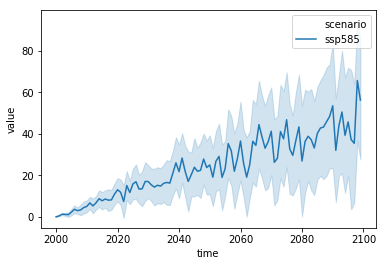

In [13]:
# NBVAL_IGNORE_OUTPUT
ScmRun.from_nc("/tmp/out-ssp585-sparse.nc").filter(
    "Surface Temperature"
).line_plot()

In [14]:
# NBVAL_IGNORE_OUTPUT
# Load all scenarios
df_append([ScmRun.from_nc(fname) for fname in glob("/tmp/out-*-sparse.nc")])

<scmdata.ScmRun (timeseries: 90, timepoints: 100)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2099-01-01T00:00:00
Meta:
	     run_id  paraset_id                        variable region scenario  \
	210      91           0  Atmospheric Concentrations|Co2  World   ssp119   
	211      94           1  Atmospheric Concentrations|Co2  World   ssp119   
	212      97           2  Atmospheric Concentrations|Co2  World   ssp119   
	213     100           3  Atmospheric Concentrations|Co2  World   ssp119   
	214     103           4  Atmospheric Concentrations|Co2  World   ssp119   
	..      ...         ...                             ...    ...      ...   
	295     135           5             Surface Temperature  World   ssp370   
	296     138           6             Surface Temperature  World   ssp370   
	297     141           7             Surface Temperature  World   ssp370   
	298     144           8             Surface Temperature  World   ssp370   
	299     147           9             Surface Te

An alternative to the sparse arrays is to specify the variables in the `extras` attribute. This adds the metadata to the netCDF file as an additional variable with the same dimensions as the data (except for `time` for obvious reasons).

In [15]:
for sce_df in large_run.groupby("scenario"):
    sce = sce_df.get_unique_meta("scenario", True)
    sce_df.to_nc(
        "/tmp/out-{}-extras.nc".format(sce),
        dimensions=["run_id"],
        extras=["paraset_id"],
    )

In [16]:
# NBVAL_IGNORE_OUTPUT
xr.load_dataset("/tmp/out-ssp585-extras.nc")

<xarray.Dataset>
Dimensions:                          (run_id: 30, time: 100)
Coordinates:
  * time                             (time) float64 9.467e+08 ... 4.071e+09
  * run_id                           (run_id) int64 150 151 152 ... 177 178 179
Data variables:
    paraset_id                       (run_id) int64 0 0 0 1 1 1 ... 8 8 8 9 9 9
    atmospheric_concentrations__co2  (run_id, time) float64 nan nan ... nan nan
    radiative_forcing                (run_id, time) float64 nan nan ... 80.43
    surface_temperature              (run_id, time) float64 0.0 0.09832 ... nan
Attributes:
    created_at:        2020-04-17T05:46:12.677299
    _scmdata_version:  0.4.0+130.g056c077.dirty

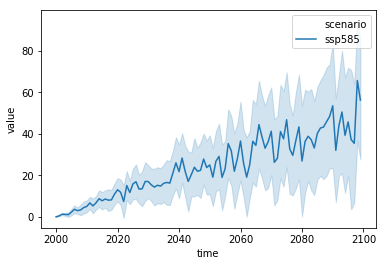

In [17]:
# NBVAL_IGNORE_OUTPUT
ScmRun.from_nc("/tmp/out-ssp585-extras.nc").filter(
    "Surface Temperature"
).line_plot()